# Mintervention Aware Optimization

This notebook demonstrates Python algorithms for optimal control constrained by keepout sets. We compare barrier methods to the new Mintervention-aware optimization

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
%matplotlib inline

# David McPherson's personal colors for plotting:
colors = [['#cf4c34','#078752','#6333ed','#d6ca54','#0ca0ad','#2ea62a','#c96b0d','#d947bb'],
          ['#4C1C13','#073824','#000000','#000000','#000000','#000000','#000000','#000000'],
          ['#FF745A','#0BD480','#EEEEEE','#EEEEEE','#EEEEEE','#EEEEEE','#EEEEEE','#EEEEEE']]

In [2]:
# Import custom libraries
import dlqr
import dynamics as dyn

# Functions for creating trajectories
# Our Dubins car must steer around another dubins car (the AVoid car)
def synthesize_straightline_trajectories(dynamic,timestep_length,time_horizon):
    # Synthetic (non-loaded) trajectories
    # Starting trajectory for reactive vehicle
    seed_states = np.zeros((dynamic.dimZ,time_horizon+1))
    seed_control = np.zeros((dynamic.dimU,time_horizon))
    seed_states[:,0] = np.array([-6,0,0])
    for i in np.arange(0,time_horizon):
        seed_control[:,i] = np.zeros((dynamic.dimU,))
        seed_states[:,i+1] = seed_states[:,i] + timestep_length * dynamic.f(seed_states[:,i],seed_control[:,i])

    # Trajectory of the AVoid car
    AVstate = np.array([2.5,-1,np.pi/2]) 
    AVcontrol = np.zeros((dynamic.dimU,time_horizon+1))
    AVcontrol = np.zeros((dynamic.dimU,time_horizon+1))
    AVstates = np.zeros((dynamic.dimZ,time_horizon+1))
    AVstates[:,0] = AVstate
    for i in np.arange(0,time_horizon):
        AVcontrol[:,i] = np.zeros((dynamic.dimU,))
        AVstates[:,i+1] = AVstates[:,i] + timestep_length * dynamic.f(AVstates[:,i],AVcontrol[:,i])
    
    return AVstates,seed_states,seed_control

# Our Dubins car must steer around a fixed obstacle
def synthesize_straightline_trajectory_and_obstacle(dynamic,timestep_length,time_horizon,startX,startY):
    # Synthetic (non-loaded) trajectories
    # Starting trajectory for reactive vehicle
    seed_states = np.zeros((dynamic.dimZ,time_horizon+1))
    seed_control = np.zeros((dynamic.dimU,time_horizon))
    seed_states[:,0] = np.array([-6,0,0])
    for i in np.arange(0,time_horizon):
        seed_control[:,i] = np.zeros((dynamic.dimU,))
        seed_states[:,i+1] = seed_states[:,i] + timestep_length * dynamic.f(seed_states[:,i],seed_control[:,i])

    # Trajectory of autonomous vehicle (AV)
    AVstates = np.zeros((dynamic.dimZ,time_horizon+1))
    #    AVstates[:,0] = np.array([5,4,0,0])
    AVstates[:,0] = np.array([startX,startY,0])
    for i in np.arange(0,time_horizon):
        AVstates[:,i+1] = np.array([startX,startY,0])
    
    return AVstates,seed_states,seed_control

## Create the initial trajectories

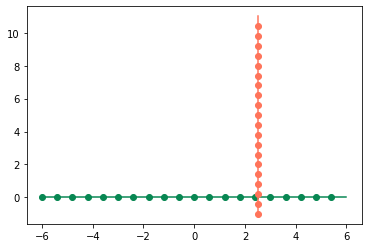

In [3]:
dubins = dyn.DubinsCarBrakelessDynamics()
timestep_length = 0.01

obstacle_trajectory,states_init,control_init = synthesize_straightline_trajectories(dubins,timestep_length,400)
N = control_init.shape[1]

plt.plot(states_init[0,:],states_init[1,:],color=colors[0][1])
plt.plot(states_init[0,np.arange(0,N,20)],states_init[1,np.arange(0,N,20)],'ro',color=colors[0][1])

plt.plot(obstacle_trajectory[0,:],obstacle_trajectory[1,:],color=colors[2][0])
plt.plot(obstacle_trajectory[0,np.arange(0,N,20)],obstacle_trajectory[1,np.arange(0,N,20)],'ro',color=colors[2][0])

[-6, 2, -2, 2]

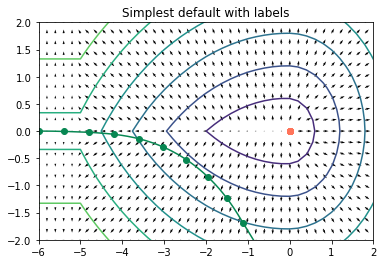

In [4]:
import level_sets
learnedSafety = level_sets.GriddedLevelSetFunction("dubins_reachset.json") # radius of obstacle is 1.8
dubIntSafety = level_sets.AnalyticDoubleIntegratorLS(0,1,1)
doubledSafety = level_sets.DecoupledLevelSetFunction(dubIntSafety,dubIntSafety)

def f(x,y):
    return(learnedSafety.value([x,y,0]) )

#'''
delta = 0.2
x = np.arange(-6.0, 3.0, delta)
y = np.arange(-3.0, 3.0, delta)
X, Y = np.meshgrid(x, y)
z = np.array([learnedSafety.value([ex,ey,0]) for ex,ey in zip(X.flatten(),Y.flatten())])
#z = np.array([dubIntSafety.value([ex,ey]) for ex,ey in zip(X.flatten(),Y.flatten())])
Z = z.reshape(X.shape)
#Z = [learnedSafety.value([x,y,0]) for x,y in zip(X,Y)]
#Z = sliceSafety(X, Y)

u = np.array([learnedSafety.gradient([ex,ey,0])[0] for ex,ey in zip(X.flatten(),Y.flatten())])
#u = 3*np.array([dubIntSafety.gradient([ex,ey])[0] for ex,ey in zip(X.flatten(),Y.flatten())])
U = u.reshape(X.shape)
v = np.array([learnedSafety.gradient([ex,ey,0])[1] for ex,ey in zip(X.flatten(),Y.flatten())])
#v = 3*np.array([dubIntSafety.gradient([ex,ey])[1] for ex,ey in zip(X.flatten(),Y.flatten())])
V = v.reshape(X.shape)

plt.figure()
CS = plt.contour(X, Y, Z)
plt.quiver(X,Y, U,V)
#plt.clabel(CS, inline=1, fontsize=10)
plt.title('Simplest default with labels')
#'''

dubins = dyn.DubinsCarBrakelessDynamics()
safe_dubins = dyn.MinimumInterventionDynamicsWrapper(dubins,learnedSafety)
timestep_length = 0.01

obstacle_trajectory,states_init,control_init = synthesize_straightline_trajectory_and_obstacle(safe_dubins,timestep_length,400,0,0)
N = control_init.shape[1]

plt.plot(states_init[0,:],states_init[1,:],color=colors[0][1])
plt.plot(states_init[0,np.arange(0,N,20)],states_init[1,np.arange(0,N,20)],'ro',color=colors[0][1])

plt.plot(obstacle_trajectory[0,:],obstacle_trajectory[1,:],color=colors[2][0])
plt.plot(obstacle_trajectory[0,np.arange(0,N,20)],obstacle_trajectory[1,np.arange(0,N,20)],'ro',color=colors[2][0])
plt.axis([-6,2,-2,2])

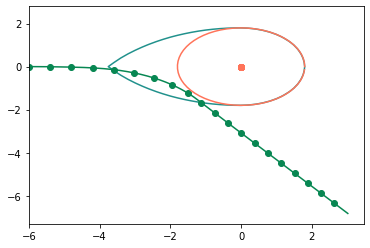

In [5]:
plt.figure()
CS = plt.contour(X, Y, Z, 0)

plt.plot(states_init[0,:],states_init[1,:],color=colors[0][1])
plt.plot(states_init[0,np.arange(0,N,20)],states_init[1,np.arange(0,N,20)],'ro',color=colors[0][1])

plt.plot(1.8*np.cos(np.arange(0,2*np.pi,0.1)),1.8*np.sin(np.arange(0,2*np.pi,0.1)),color=colors[2][0])
plt.plot(obstacle_trajectory[0,:],obstacle_trajectory[1,:],color=colors[2][0])
plt.plot(obstacle_trajectory[0,np.arange(0,N,20)],obstacle_trajectory[1,np.arange(0,N,20)],'ro',color=colors[2][0])

## Set the Agent's goals

In [6]:
# Define the Agent's objective function
import objective_functions as of
import quadratic_objectives as qof
import avoidance_objective as caof

runningControlCost = qof.QuadraticControlCost(dlqr.QuadraticForm(dubins.dimU,np.diag([0.01]),np.zeros((dubins.dimU,1)),0))

Qprox = np.diag([1,1,0])
#goal_state = states_init[:,N]
goal_state = np.array([4,0,0])
terminalCost = of.TerminalCost(qof.QuadraticStateCost(
        dlqr.QuadraticForm(dubins.dimZ,Qprox,
                           -2*Qprox*np.matrix(goal_state).T,
                           np.dot(np.dot(goal_state.transpose(),Qprox),goal_state) )
        ) * 40)


#Agent_objective = caof.CollisionAvoidance(obstacle_trajectory)*0.1 + runningControlCost*1 + adaptationPenalty*0.0002
Agent_objective = runningControlCost*1

## Optimize trajectory with iLQR

Initialization's cost is  19.009556103581613
1 14.260394761949033
2 11.162920245524282
3 7.154802263638697
4 5.2233463848126345
5 3.383677193600272
6 2.2688733754285217
7 1.5478207604441847
8 0.8060854637607879
9 0.4100322212444067
10 0.297433757044393
11 0.17005262344897074
12 0.10951409855525632
13 0.1098527634410483
14 0.08089588090777541


<function matplotlib.pyplot.show(*args, **kw)>

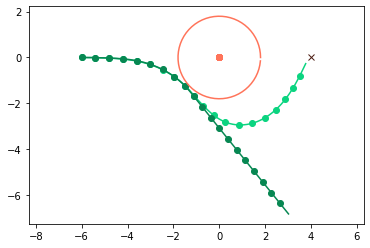

In [7]:
import ilqr

mintervener_method_states = ilqr.iterative_LQR(states_init,control_init,safe_dubins,Agent_objective,timestep_length,terminal_cost = terminalCost,neverRetreat=True,ITER_NUM=15)
plt.plot(4,0,'x',color=colors[1][0])

# Plot the resultant ghostly trajectories
#plt.figure(figsize=(10,10))
plt.plot(mintervener_method_states[0,:],mintervener_method_states[1,:],color=colors[2][1])
plt.plot(mintervener_method_states[0,np.arange(0,N,20)],mintervener_method_states[1,np.arange(0,N,20)],'ro',color=colors[2][1])
plt.plot(states_init[0,:],states_init[1,:],color=colors[0][1])
plt.plot(states_init[0,np.arange(0,N,20)],states_init[1,np.arange(0,N,20)],'ro',color=colors[0][1])

plt.plot(obstacle_trajectory[0,:],obstacle_trajectory[1,:],color=colors[2][0])
plt.plot(obstacle_trajectory[0,np.arange(0,N,20)],obstacle_trajectory[1,np.arange(0,N,20)],'ro',color=colors[2][0])
plt.plot(1.8*np.cos(np.arange(0,2*np.pi,0.1)),1.8*np.sin(np.arange(0,2*np.pi,0.1)),color=colors[2][0])

plt.axis('equal')
plt.show
#plt.plot(statesLin[0,:],statesLin[1,:],color=colors[0][2])

Initialization's cost is  20.57917686889464
1 1187.671222910438
2 1197.352791874962
3 1198.5398467681161
4 1198.4538328446274
5 1211.29514743093
6 1210.478873302969
7 1210.048016828029
8 1209.921688680657
9 1209.8733635750345
10 1209.8468999987235
11 1209.8283521939209
12 1209.8140338912124
13 1209.8027440073172
14 1209.7938850931819


<function matplotlib.pyplot.show(*args, **kw)>

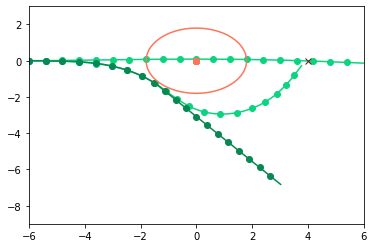

In [8]:
barrier_objective = caof.CollisionAvoidance3(obstacle_trajectory)*0.1 + runningControlCost*1
barrier_method_states = ilqr.iterative_LQR(states_init,control_init,dubins,barrier_objective,timestep_length,terminal_cost = terminalCost,neverRetreat=True,ITER_NUM=15)

plt.plot(mintervener_method_states[0,:],mintervener_method_states[1,:],color=colors[2][1])
plt.plot(mintervener_method_states[0,np.arange(0,N,20)],mintervener_method_states[1,np.arange(0,N,20)],'ro',color=colors[2][1])

plt.plot(barrier_method_states[0,:],barrier_method_states[1,:],color=colors[2][1])
plt.plot(barrier_method_states[0,np.arange(0,N,20)],barrier_method_states[1,np.arange(0,N,20)],'ro',color=colors[2][1])

plt.plot(states_init[0,:],states_init[1,:],color=colors[0][1])
plt.plot(states_init[0,np.arange(0,N,20)],states_init[1,np.arange(0,N,20)],'ro',color=colors[0][1])

plt.plot(obstacle_trajectory[0,:],obstacle_trajectory[1,:],color=colors[2][0])
plt.plot(obstacle_trajectory[0,np.arange(0,N,20)],obstacle_trajectory[1,np.arange(0,N,20)],'ro',color=colors[2][0])

plt.plot(4,0,'x',color=colors[1][0])
plt.plot(1.8*np.cos(np.arange(0,2*np.pi,0.1)),1.8*np.sin(np.arange(0,2*np.pi,0.1)),color=colors[2][0])

plt.axis([-6,6,-9,3])
plt.show

In [50]:
import dlqr

timestep_length = 0.1
horizon = 8
A = np.eye(2) + timestep_length*np.array([[0,1],[0,0]])
B = timestep_length*np.array([[0],[1]])
Q = timestep_length*np.diag([0,1])
R = timestep_length*np.zeros((1,1))
X = 1/(10-horizon)*np.diag([1,0])

Qq = dlqr.QuadraticForm(2,Q,np.zeros((2,1)),0)
Rq = dlqr.QuadraticForm(2,R,np.zeros((1,1)),0)
Xq = dlqr.QuadraticForm(2,X,np.zeros((2,1)),0)

K,k,Xprime,eigVals = dlqr.onestep_dlqr_affine(A,B,Qq,Rq,Xq,0.1)
print(K)

for i in np.arange(0,horizon/timestep_length):
    K,k,Xprime,eigVals = dlqr.onestep_dlqr_affine(A,B,Qq,Rq,Xprime,0)
    #print(horizon-(i+1)*timestep_length,K)

[[-0. -0.]]


# Animate the trajectories
If you like you can generate a video to better visualize the reactions. Note that you will need to manually set the viewing window `xlim` and `ylim` in the `add_subplot` function.

AttributeError: 'FuncAnimation' object has no attribute 'to_html5_video'

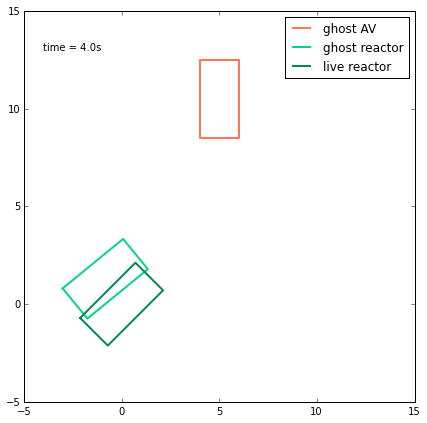

In [8]:
# Animate the trajectories
from matplotlib import animation, rc # import the animation libraries
from IPython.display import HTML # import libraries to embed animation in Jupyter
%matplotlib inline

# Create the figure
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-5, 15), ylim=(-5, 15))
#ax.grid()

# Initialize the lines for drawing the cars
obstacle, = ax.plot([], [], '-', lw=2, color = colors[2][0])
trajectory, = ax.plot([], [], '-', lw=2, color = colors[2][1])
initialization, = ax.plot([], [], '-', lw=2, color = colors[0][1])
# Labeling
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
plt.legend(["ghost AV","ghost Agent","live Agent"])

# Convenience function for plotting rectangular perimeter of a 4 meter by 2 meter car
def drawCar(line,state):
    x = state[0]
    y = state[1]
    s = np.sin(state[2])
    c = np.cos(state[2])
    lon = [c*2, s*2]
    lat = [s*1,-c*1]
    xpoints = [x+lat[0]+lon[0],x-lat[0]+lon[0],x-lat[0]-lon[0],x+lat[0]-lon[0],x+lat[0]+lon[0]]
    ypoints = [y+lat[1]+lon[1],y-lat[1]+lon[1],y-lat[1]-lon[1],y+lat[1]-lon[1],y+lat[1]+lon[1]]
    line.set_data(xpoints,ypoints)

# Function for intializing the animation
def init():
    trajectory.set_data([], [])
    obstacle.set_data([], [])
    initialization.set_data([], [])
    time_text.set_text('')
    return trajectory,obstacle,initialization, time_text

# Animation function called each time step
def animate(i):
    # Draw the cars at this time step
    drawCar(trajectory,trajectory_states[:,i])
    drawCar(initialization,initialization_states[:,i])
    drawCar(obstacle,obstacle_states[:,i])
    # Update the time label
    time_text.set_text(time_template % (i*timestep_length))
    
    return trajectory,obstacle,initialization,time_text

# Generate the animation
anim = animation.FuncAnimation(fig, animate, np.arange(1, len(obstacle_trajectory[0,:])),
                              interval=25, blit=True, init_func=init)
# Save the animation to a file (with 15 frames per second)
mywriter = animation.FFMpegWriter(fps=15) # increase number for faster animation
anim.save('cars.mp4', writer=mywriter)
HTML(anim.to_html5_video())
rc('animation', html='html5')
#anim
#plt.show()